In [1]:
!pip install py_vncorenlp -q  # Cài đặt thư viện VnCoreNLP cho xử lý ngôn ngữ tự nhiên tiếng Việt

In [2]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import AutoModelForSequenceClassification, RobertaForSequenceClassification, AutoTokenizer, get_scheduler, AutoModel
from torch.optim import AdamW
from accelerate.utils import set_seed
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from py_vncorenlp import  VnCoreNLP
import py_vncorenlp

In [ ]:
# Automatically download VnCoreNLP components from the original repository
# and save them in some local machine folder
py_vncorenlp.download_model(save_dir='./')

In [4]:
!apt-get update
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null

Get:1 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1225 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease              
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]      
Get:6 https://packages.cloud.google.com/apt cloud-sdk InRelease [1616 B]       
Get:7 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1593 kB]
Get:9 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [22.5 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [128 kB]     
Get:11 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [3017 kB]
Get:12 https://packages.cloud.google.com/apt cloud-sdk/main all Packages [1454 kB]
Ge

In [5]:
# Load the word and sentence segmentation component
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='./')

2024-06-06 14:34:08 INFO  WordSegmenter:24 - Loading Word Segmentation model


In [31]:
train = pd.read_csv('/kaggle/input/balance-gold-dataset/balance_train.csv', sep=',')

In [32]:
test = pd.read_csv('/kaggle/input/balance-gold-dataset/balance_test.csv', sep=',')

In [33]:
train.head()

,BID_PRICE,CONTENT,DATE,PRICE,TIME,TITLE,labels
0,66.50,"Lợi suất trái phiếu toàn cầu đang tăng lên, đi...",24/06/2023,67.10,08:30,Giá vàng hôm nay 24/6: Vọt lên cao rồi cắm đầu...,increase
1,67.65,Tài khoản không đủ để thực hiện chức năng này....,14/07/2022,68.25,09:00,Giá vàng hôm nay 14/7: Vàng trong nước tăng ng...,increase
2,56.75,Giá vàng hôm nay ngày 12/7/2021 biến động từ g...,12/07/2021,57.50,08:55,Giá vàng hôm nay ngày 12/7/2021: biến động nhẹ...,decrease
3,68.20,"Hôm qua, thị trường nhận thông tin về báo cáo ...",05/10/2023,68.90,09:20,Giá vàng hôm nay 5/10: Chuyên gia dự đoán lạc ...,decrease
4,74.30,Giá vàng bật tăng khi căng thẳng quân sự leo t...,30/01/2024,76.80,08:55,"Giá vàng hôm nay 30/1: Nhiều yếu tố hỗ trợ, và...",increase


In [34]:
test.head()

,BID_PRICE,CONTENT,DATE,PRICE,TIME,TITLE,labels
0,67.85,. Sự tin tưởng của khu vực kinh doanh vào một ...,25/06/2022,68.65,09:45,"Giá vàng hôm nay 25/6: ""Hụt hơi"" phiên cuối tu...",decrease
1,82.80,Xu hướng mua ròng vàng miếng của các quốc gia ...,10/04/2024,84.80,08:20,"Giá vàng hôm nay 10/4: Sau ""cơn điên"" tăng giá...",increase
2,66.45,Mặc dù tâm lý lạc quan đã quay trở lại nhưng h...,10/07/2023,67.05,08:30,"Giá vàng hôm nay 10/7: Vàng đi ngang, giới đầu...",decrease
3,56.35,Giá vàng hôm nay ngày 5/1/2021 tăng từ 50.000 ...,05/01/2021,56.90,10:20,Giá vàng hôm nay ngày 5/1/2021: vàng tiếp tục ...,increase
4,68.80,. Giá vàng tiếp đà tăng khi thị trường tài chí...,09/06/2022,69.70,08:30,"Giá vàng hôm nay 9/6: Được hỗ trợ mạnh, vàng p...",increase


In [36]:
def get_config():
    config = {'batch_size': 16,
              'model_name': 'vinai/phobert-base-v2',
              'lr': 10 ** -5,
              'num_labels': 2,
              'epochs': 5,
              'num_warmup_steps': 0,
              'seed': 42, 
              'max_length': 256,
              'eos': '[SEP]'
              
    }
    return config 

In [37]:
config = get_config()

### Creating dataset

In [38]:
class get_dataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        super().__init__()
        self.titles = df['TITLE'].values
        self.content = df['CONTENT'].values
        self.labels = df['labels'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        title = self.titles[idx]
        content = self.content[idx]
        if self.labels[idx] == "increase":
            label = 1
        elif self.labels[idx] == "decrease":
            label = 0
        #input_data = rdrsegmenter.word_segment(title)[0] + '[SEP]' + rdrsegmenter.word_segment(content)[0]

        return rdrsegmenter.word_segment(title)[0], label

In [39]:
train_dataset = get_dataset(df=train)
test_dataset  = get_dataset(df=test)

In [40]:
train_dataset[226]

('Giá vàng ngày 6/8/2020 : sắp chạm ngưỡng 60 triệu[SEP]Giá vàng lúc 9h10 ngày 6/8/2020 sắp chạm ngưỡng 60 triệu với mức tăng từ 350.000 đến 800.000 đồng / lượng .',
 1)

In [41]:
def create_dataloader(dataset: Dataset, config: dict, is_train: bool) -> DataLoader:

    return DataLoader(dataset=dataset, batch_size=config['batch_size'], shuffle=is_train, drop_last=is_train) 

In [42]:
train_loader = create_dataloader(train_dataset, config, True)
test_loader  = create_dataloader(test_dataset, config, False)

### Training

In [43]:
config['model_name']

'vinai/phobert-base-v2'

In [44]:
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

### Training

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create model
model = AutoModelForSequenceClassification.from_pretrained(config['model_name'], num_labels=config['num_labels'])

# create optimizer
optimizer = AdamW(params=model.parameters(), lr=config['lr'])

train_loader = create_dataloader(train_dataset, config, True)
test_loader = create_dataloader(test_dataset, config, False)

num_training_steps = config['epochs'] * len(train_loader)
# create lr scheduler
lr_scheduler = get_scheduler(
    'cosine', optimizer=optimizer, num_warmup_steps=config['num_warmup_steps'], num_training_steps=num_training_steps
)

# create loss function
loss_fn = torch.nn.CrossEntropyLoss()

model.to(device)
epochs = config['epochs']

# Early stopping parameters
patience = 2
best_eval_loss = float('inf')
early_stopping_counter = 0

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
# training
print("========== Start training ==========")
for epoch in range(epochs):
    model.train()
    training_loss = 0
    for inputs, labels in train_loader:
        inputs = tokenizer(inputs, return_tensors='pt', max_length=config['max_length'], padding='longest', truncation=True).to(device)
        labels = labels.to(device)

        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        training_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    training_loss /= len(train_loader)

    # testing
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = tokenizer(inputs, return_tensors='pt', max_length=config['max_length'], padding='longest', truncation=True).to(device)
            labels = labels.to(device)

            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            eval_loss += loss.item()

    eval_loss /= len(test_loader)
    print(f"Epoch {epoch + 1}, Training loss: {training_loss:.4f}, Eval loss: {eval_loss:.4f}")

    # Check for early stopping
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered")
        break

print("========== End training ==========")

========== Start training ==========
Epoch 1, Training loss: 0.6344, Eval loss: 0.4193
Epoch 2, Training loss: 0.3401, Eval loss: 0.2514
Epoch 3, Training loss: 0.2131, Eval loss: 0.2048
Epoch 4, Training loss: 0.1708, Eval loss: 0.2060
Epoch 5, Training loss: 0.1612, Eval loss: 0.2057
Early stopping triggered
========== End training ==========


### Inference

In [47]:
preds = []

In [48]:
model.eval()
with torch.no_grad(): 
    for inputs, labels in test_loader:
        inputs = tokenizer(inputs, return_tensors='pt', max_length=config['max_length'], padding='longest', truncation=True).to(device)
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        _, predicted_labels = torch.max(probs, dim=1)
        preds.extend(predicted_labels.detach().cpu().tolist()) 

In [49]:
labels = test['labels'].values
labels = [1 if label == 'increase' else 0 for label in labels]

In [50]:
acc  = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

In [51]:
print(f"========== Evaluation Metrics ==========")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"========================================")

========== Evaluation Metrics ==========
Accuracy  : 0.9392
Precision : 0.9474
Recall    : 0.9351
F1 Score  : 0.9412


Confusion metrics

Confusion matrix is: [[67  4]
 [ 5 72]]


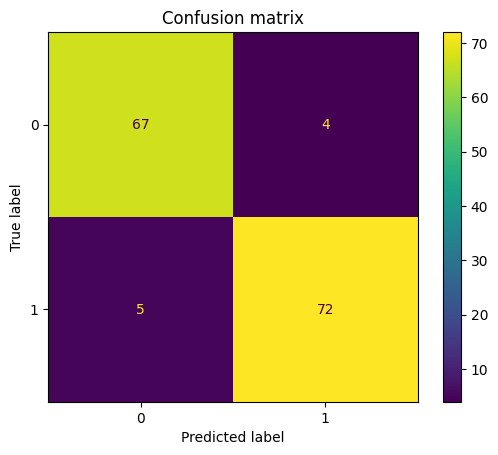

In [52]:
cfn = confusion_matrix(labels, preds)
print(f"Confusion matrix is: {cfn}")
ConfusionMatrixDisplay.from_predictions(labels, preds)
plt.title('Confusion matrix')
plt.show()